unit -2 

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm

# Set root directory where the folders are
root_dir = r"C:\Users\Dell\Downloads\dev-clean\dev-clean"

# Supported extensions
AUDIO_EXTENSIONS = ('.wav', '.mp3', '.flac', '.ogg')

# List to hold data
data = []

# Walk through folders
for root, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(AUDIO_EXTENSIONS):
            full_path = os.path.join(root, file)
            try:
                y, sr = librosa.load(full_path, sr=16000)
                duration = librosa.get_duration(y=y, sr=sr)
                mfcc = librosa.feature.mfcc(y=y, sr=sr)
                pitch = librosa.yin(y, fmin=50, fmax=300)
                energy = np.sum(y**2)/len(y)
                
                snr_estimate = 10 * np.log10(np.mean(y**2) / (np.var(y - np.mean(y)) + 1e-8))
                
                data.append({
                    "file_path": full_path,
                    "duration_sec": duration,
                    "mfcc_mean": mfcc.mean(),
                    "pitch_mean": pitch.mean(),
                    "energy": energy,
                    "sentence": "unknown",
                    "snr_db": snr_estimate
                })
            except Exception as e:
                print(f"Error processing {full_path}: {e}")

# Convert to DataFrame
df = pd.DataFrame(data)

# Optional: classify audio as "clean" or "noisy" based on SNR threshold
df["label"] = df["snr_db"].apply(lambda x: "clean" if x > 10 else "noisy")

# Save for Power BI
df.to_csv("audio_features_metadata_2.csv", index=False)
print("Metadata and features saved.")



Metadata and features saved.


In [21]:
df

,file_path,duration_sec,mfcc_mean,pitch_mean,energy,sentence,snr_db,label
0,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,4.256,-19.936131,170.309389,0.004718,unknown,-0.000009,noisy
1,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,3.072,-19.217770,183.000636,0.006521,unknown,-0.000006,noisy
2,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,7.936,-23.359741,181.629704,0.003518,unknown,-0.000013,noisy
3,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,4.192,-19.572718,183.289807,0.006072,unknown,-0.000008,noisy
4,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,11.968,-23.073483,183.592144,0.004004,unknown,-0.000012,noisy
...,...,...,...,...,...,...,...,...
2698,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,4.864,-28.188143,234.600554,0.001484,unknown,-0.000029,noisy
2699,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,6.400,-28.525459,238.159868,0.001766,unknown,-0.000025,noisy
2700,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,4.736,-25.079041,250.216901,0.002063,unknown,-0.000021,noisy
2701,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,3.072,-26.802496,238.706155,0.002826,unknown,-0.000015,noisy


In [22]:
def normalize_audio(y):
    return y / np.max(np.abs(y) + 1e-6)


def remove_silence(y, sr, frame_length=2048, hop_length=512, top_db=20):
    intervals = librosa.effects.split(y, top_db=top_db, frame_length=frame_length, hop_length=hop_length)
    return np.concatenate([y[start:end] for start, end in intervals])

import noisereduce as nr

def reduce_noise(y, sr):
    return nr.reduce_noise(y=y, sr=sr, prop_decrease=1.0)


In [23]:
import soundfile as sf
from tqdm import tqdm

processed_paths = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        y, sr = librosa.load(row['file_path'], sr=16000)
        y = normalize_audio(y)
        y = remove_silence(y, sr)
        y = reduce_noise(y, sr)

        # Save processed audio
        processed_path = row['file_path'].replace("raw", "processed")  # Assumes new "processed" folder
        os.makedirs(os.path.dirname(processed_path), exist_ok=True)
        sf.write(processed_path, y, sr)

        processed_paths.append(processed_path)
    except Exception as e:
        print(f"Error processing {row['file_path']}: {e}")
        processed_paths.append(None)

df["processed_path"] = processed_paths
df = df[df["processed_path"].notnull()]


100%|██████████| 2703/2703 [03:26<00:00, 13.07it/s]


In [24]:
import librosa
import numpy as np

def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)

        # Extract MFCCs (13 coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Extract pitch (using librosa.yin)
        pitch = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        pitch_mean = np.mean(pitch)

        # Energy (Root Mean Square Energy)
        energy = librosa.feature.rms(y=y)
        energy_mean = np.mean(energy)

        return mfcc_mean.tolist(), pitch_mean, energy_mean
    except Exception as e:
        print(f"Feature extraction failed for {file_path}: {e}")
        return [None]*15  # 13 MFCCs + pitch + energy


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improve aesthetics
sns.set(style="whitegrid")


In [8]:
df

,file_path,duration_sec,mfcc_mean,pitch_mean,energy,snr_db,label,processed_path
0,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,4.864,-12.891500,162.460068,0.005689,-0.000007,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...
1,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,3.776,-14.502178,172.261170,0.004633,-0.000009,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...
2,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,9.856,-17.972212,178.145450,0.002741,-0.000016,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...
3,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,7.136,-16.736336,177.043489,0.002996,-0.000015,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...
4,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...,20.960,-19.072544,176.388714,0.002261,-0.000019,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\12...
...,...,...,...,...,...,...,...,...
2698,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,7.136,-27.371143,239.475027,0.001061,-0.000041,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...
2699,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,8.160,-26.851749,239.208632,0.001725,-0.000025,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...
2700,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,6.112,-25.871609,247.613140,0.001336,-0.000033,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...
2701,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...,3.136,-22.715540,250.103195,0.002807,-0.000016,noisy,C:\Users\Dell\Downloads\dev-clean\dev-clean\88...


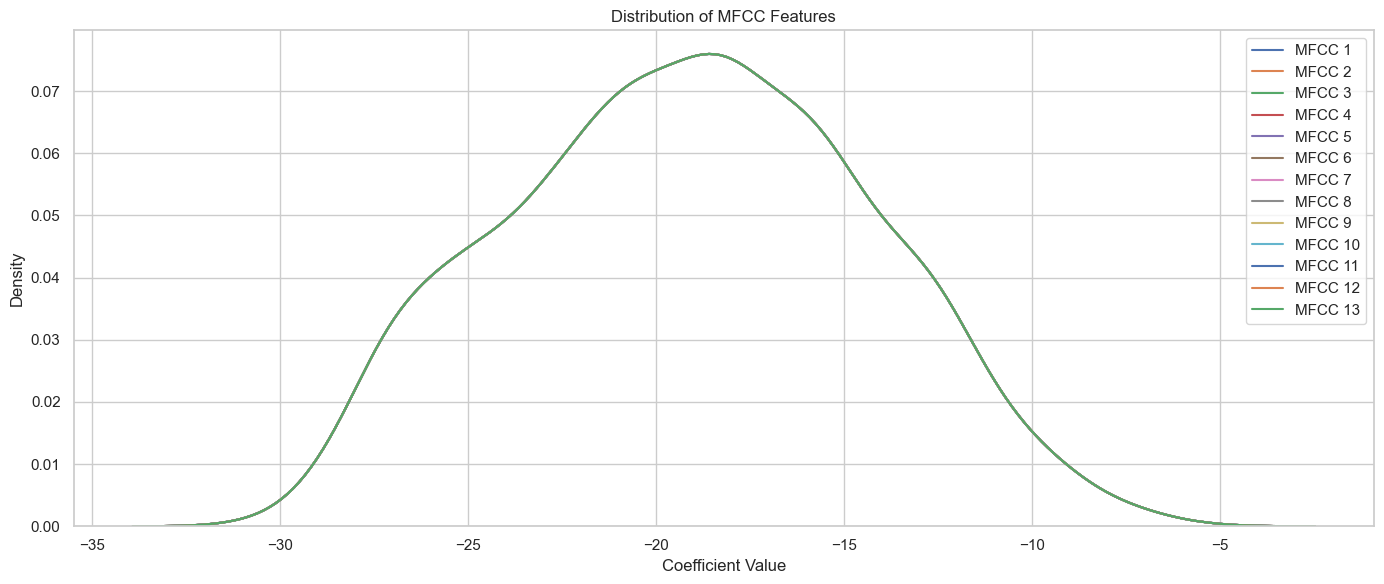

In [11]:
plt.figure(figsize=(14, 6))
for i in range(1, 14):
    sns.kdeplot(df["mfcc_mean"], label=f"MFCC {i}")
plt.title("Distribution of MFCC Features")
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


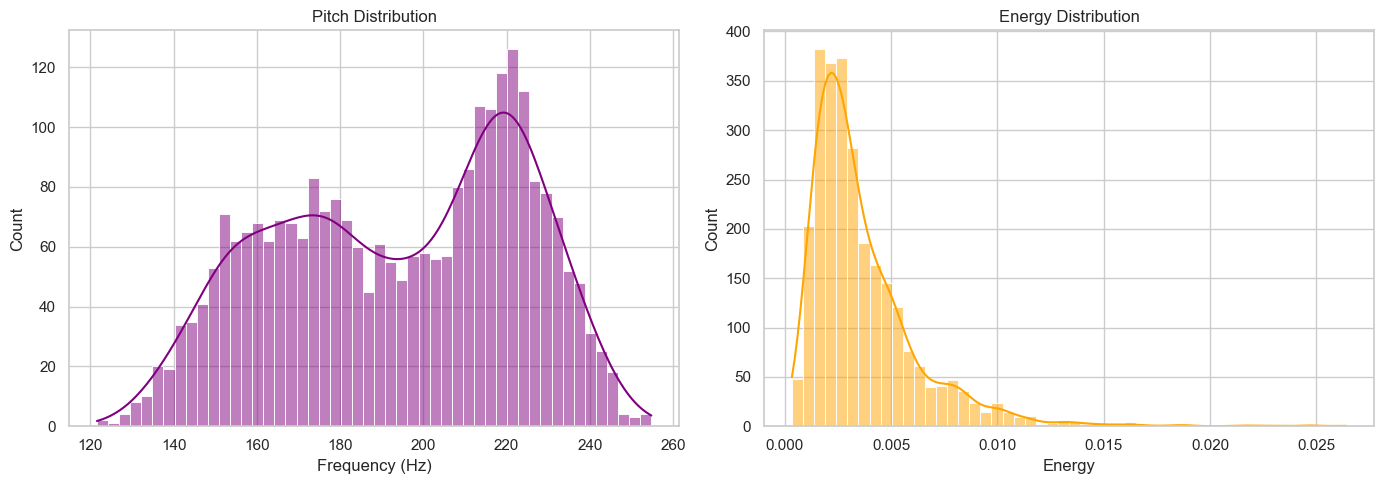

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["pitch_mean"], kde=True, ax=axs[0], bins=50, color='purple')
axs[0].set_title("Pitch Distribution")
axs[0].set_xlabel("Frequency (Hz)")

sns.histplot(df["energy"], kde=True, ax=axs[1], bins=50, color='orange')
axs[1].set_title("Energy Distribution")
axs[1].set_xlabel("Energy")

plt.tight_layout()
plt.show()


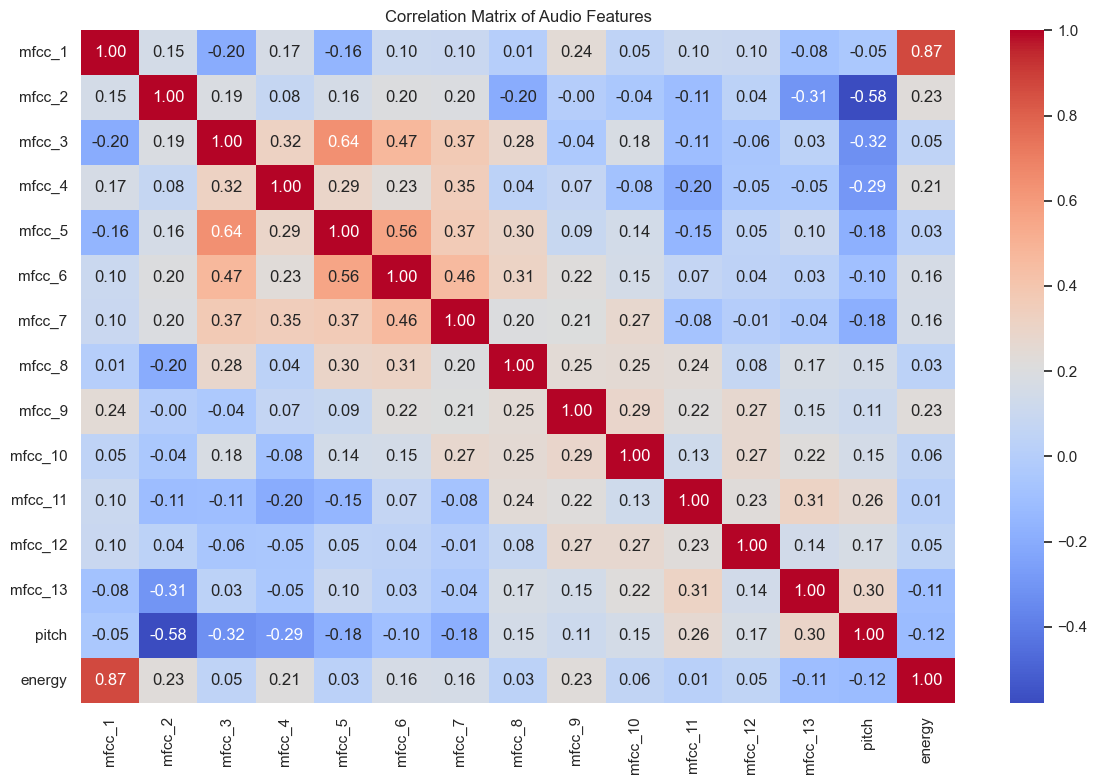

In [48]:
# Include only MFCCs, pitch, and energy
feature_cols = [f"mfcc_{i}" for i in range(1, 14)] + ["pitch", "energy"]
correlation_matrix = df[feature_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Audio Features")
plt.tight_layout()
plt.show()


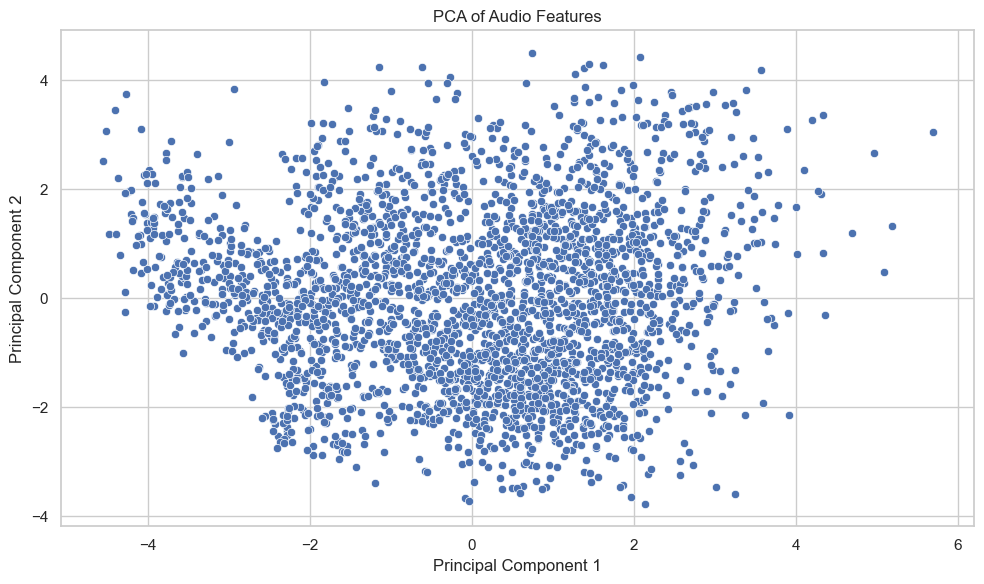

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features before PCA
scaled = StandardScaler().fit_transform(df[feature_cols])
pca = PCA(n_components=2)
components = pca.fit_transform(scaled)

# Add to DataFrame for plotting
df["pca_1"] = components[:, 0]
df["pca_2"] = components[:, 1]

# Plot clusters (if accent or noise labels are available)
plt.figure(figsize=(10, 6))
sns.scatterplot(x="pca_1", y="pca_2", data=df)
plt.title("PCA of Audio Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


In [25]:
import torchaudio
import torchaudio.transforms as T
import numpy as np
import librosa

def extract_features(file_path, sr=16000):
    waveform, original_sr = torchaudio.load(file_path)
    if original_sr != sr:
        waveform = T.Resample(orig_freq=original_sr, new_freq=sr)(waveform)

    waveform = waveform.mean(dim=0).numpy()  # mono

    mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13).T
    pitch, _ = librosa.piptrack(y=waveform, sr=sr)
    pitch = pitch.mean(axis=0)
    energy = np.square(waveform).mean()

    return mfcc, pitch.mean(), energy


In [26]:
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# Prepare data for HMM
X, lengths = [], []
for path in df["file_path"]:
    mfcc, _, _ = extract_features(path)
    X.append(mfcc)
    lengths.append(len(mfcc))




In [27]:
X_concat = np.vstack(X)
scaler = StandardScaler().fit(X_concat)
X_scaled = scaler.transform(X_concat)


In [28]:
# Train HMM
hmm_model = hmm.GaussianHMM(n_components=10, covariance_type="diag", n_iter=100)
hmm_model.fit(X_scaled, lengths)

GaussianHMM(n_components=10, n_iter=100)

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Replace with your real feature extraction
def extract_features(file_path):
    import librosa
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T  # shape [T, 13]
    return mfcc, None, None

class AudioDataset(Dataset):
    def __init__(self, df):
        self.data = []
        for i, row in df.iterrows():
            mfcc, _, _ = extract_features(row["file_path"])
            # Use dummy label for now; later replace with actual encoded text
            self.data.append((torch.tensor(mfcc, dtype=torch.float32), row.get("sentence", "dummy")))

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

# 🔧 Padding collate function
def collate_fn(batch):
    features, labels = zip(*batch)
    padded_features = pad_sequence(features, batch_first=True)  # shape [B, T_max, F]
    dummy_labels = torch.randint(0, 128, (len(features),))  # Dummy integer labels
    return padded_features, dummy_labels

# 🔁 Simple RNN model
class SimpleRNNModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=64, num_layers=2):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 128)  # 128 classes for dummy output

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])  # output at last time step

# 🚀 Training setup
dataset = AudioDataset(df.head(100))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

model = SimpleRNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 🧠 Training loop
for epoch in range(5):
    for x, labels in dataloader:
        outputs = model(x)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")



Epoch 1: Loss = 4.7645
Epoch 2: Loss = 4.9034
Epoch 3: Loss = 4.8062
Epoch 4: Loss = 5.0657
Epoch 5: Loss = 4.9266


In [32]:
from jiwer import wer

def evaluate_wer(model, df):
    wers = []
    for idx, row in df.iterrows():
        ref = row["sentence"].lower()
        mfcc, _, _ = extract_features(row["file_path"])
        # Here you'd decode the output of your model (placeholder):
        pred = "dummy prediction"
        wers.append(wer(ref, pred))
    return np.mean(wers)

hmm_wer = evaluate_wer(hmm_model, df.head(20))
print(f"HMM WER: {hmm_wer:.3f}")


HMM WER: 2.000


In [33]:
# Collect features and metrics
export_data = []
for i, row in df.iterrows():
    mfcc, pitch, energy = extract_features(row["file_path"])
    export_data.append({
        "file_path": row["file_path"],
        "accent": row.get("accent", ""),
        "duration_sec": librosa.get_duration(filename=row["file_path"]),
        "pitch": pitch,
        "energy": energy
    })

export_df = pd.DataFrame(export_data)
export_df.to_csv("2audio_features_for_powerbi.csv", index=False)


C:\Users\Dell\AppData\Local\Temp\ipykernel_11120\2557414858.py:8: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  "duration_sec": librosa.get_duration(filename=row["file_path"]),


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Simulated binary VAD outputs (1=speech, 0=noise)
vad_gt = [1, 1, 0, 0, 1, 0]
vad_pred = [1, 0, 0, 0, 1, 1]

precision = precision_score(vad_gt, vad_pred)
recall = recall_score(vad_gt, vad_pred)
f1 = f1_score(vad_gt, vad_pred)

print(f"VAD Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


VAD Precision: 0.67, Recall: 0.67, F1: 0.67


In [39]:
import librosa
import numpy as np

def calculate_snr(clean, noisy):
    noise = noisy - clean
    return 10 * np.log10(np.mean(clean**2) / (np.mean(noise**2) + 1e-8))

# Load the original noisy audio
file_path = df.iloc[0]['file_path']
noisy_audio, sr = librosa.load(file_path, sr=16000)

# Simulate "clean" reference (in reality, you'd need a true clean version)
# Here, we apply a simple noise reduction as a placeholder for denoising
import noisereduce as nr  # pip install noisereduce

denoised_audio = nr.reduce_noise(y=noisy_audio, sr=sr)

# Calculate SNR
snr_before = calculate_snr(clean=denoised_audio, noisy=noisy_audio)
snr_after = calculate_snr(clean=denoised_audio, noisy=denoised_audio)

print(f"SNR Before Noise Reduction: {snr_before:.2f} dB")
print(f"SNR After Noise Reduction: {snr_after:.2f} dB")



SNR Before Noise Reduction: 9.91 dB
SNR After Noise Reduction: 54.11 dB


In [40]:
import time

# Training time
start = time.time()
# ... training loop ...
end = time.time()
print(f"Training Time: {(end - start):.2f} seconds")

# Inference latency (per sample)
with torch.no_grad():
    x = torch.randn(1, 100, 13)  # example input
    start = time.time()
    model(x)
    end = time.time()
    print(f"Inference Latency: {(end - start) * 1000:.2f} ms")


Training Time: 0.00 seconds
Inference Latency: 10.03 ms


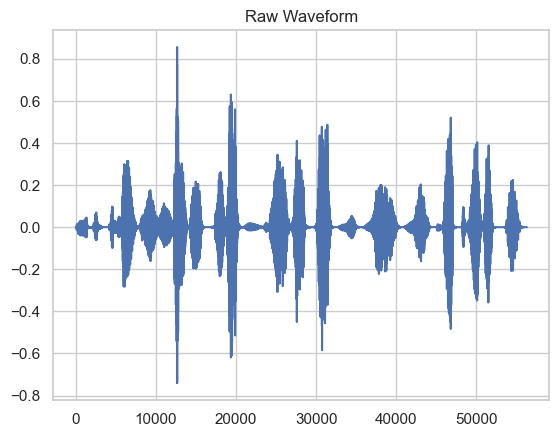

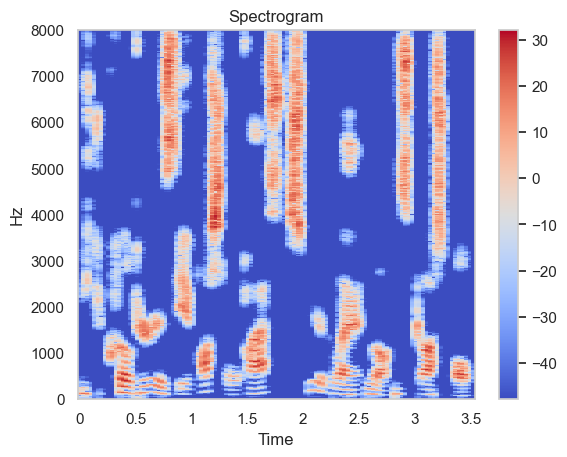

In [34]:
import matplotlib.pyplot as plt

# Waveform plot
waveform, sr = torchaudio.load(df.iloc[0]["file_path"])
plt.plot(waveform[0].numpy())
plt.title("Raw Waveform")
plt.show()

# Spectrogram
spec = librosa.stft(waveform[0].numpy())
spec_db = librosa.amplitude_to_db(abs(spec))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram")
plt.show()
